This HW is heavily based on Yury Kashnitsky and @JustHeuristic materials

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler

## Part 1: Exploring OLS and Lasso in a regression task

**We are working with UCI Wine quality dataset (you need to download it and put into the directory alongside the jupyter notebook).**

<img src='https://mlcourse.ai/_images/wine_quality.jpg' width=30%>


In [2]:
data = pd.read_csv("winequality-white.csv", sep=",")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


**Separate the target feature, split data in 7:3 proportion (30% form a holdout set, use random_state=17), and preprocess data with `StandardScaler`.**

In [5]:
x = data.iloc[:,:-1] # you code here
y=data['quality']
X_train, X_holdout, y_train, y_holdout = train_test_split(x,y,test_size=0.3,random_state=17) # you code here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # you code here
X_holdout_scaled = scaler.transform(X_holdout) # you code here

## 1.1 Linear regression

**Train a simple linear regression model (Ordinary Least Squares).**

In [6]:
linreg = LinearRegression()# you code here
linreg.fit(X_train_scaled,y_train) # you code here
y_pred_train=linreg.predict(X_train_scaled)
mean_train=np.mean((y_pred_train-y_train)**2)
y_pred_test=linreg.predict(X_holdout_scaled)
mean_test=np.mean((y_pred_test-y_holdout)**2)

**<font color='red'>Question 1:</font> What are mean squared errors of model predictions on train and holdout sets?**

In [7]:
print("Mean squared error (train): %.3f" %mean_train) # you code here
print("Mean squared error (test): %.3f" %mean_test) # you code here

Mean squared error (train): 0.558
Mean squared error (test): 0.584


**Sort features by their influence on the target feature (wine quality). Beware that both large positive and large negative coefficients mean large influence on target. It's handy to use `pandas.DataFrame` here.**

**<font color='red'>Question 2:</font> Which feature this linear regression model treats as the most influential on wine quality?**

In [8]:
linreg.intercept_,linreg.coef_

(5.876896149358229,
 array([ 9.78219223e-02, -1.92259947e-01, -1.83224449e-04,  5.38164096e-01,
         8.12724353e-03,  4.21804406e-02,  1.43040227e-02, -6.65720472e-01,
         1.50036006e-01,  6.20533605e-02,  1.29533447e-01]))

In [9]:
x.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [10]:
linreg_coef = pd.DataFrame(np.array([linreg.coef_,abs(linreg.coef_)]).T,index=x.columns) # you code here
linreg_coef.sort_values(by=[1],ascending=False) # you code here

,0,1
density,-0.665720,0.665720
residual sugar,0.538164,0.538164
volatile acidity,-0.192260,0.192260
pH,0.150036,0.150036
alcohol,0.129533,0.129533
fixed acidity,0.097822,0.097822
sulphates,0.062053,0.062053
free sulfur dioxide,0.042180,0.042180
total sulfur dioxide,0.014304,0.014304
chlorides,0.008127,0.008127


## 1.2 Lasso regression

**Train a LASSO model with $\alpha = 0.01$ (weak regularization) and scaled data. Again, set random_state=17.**

In [11]:
lasso1 = Lasso(alpha=0.01,random_state=17) # you code here
lasso1.fit(X_train_scaled,y_train) # you code here
y_pred_train_las1=lasso1.predict(X_train_scaled)
mean_train_las1=np.mean((y_pred_train_las1-y_train)**2)
y_pred_test_las1=lasso1.predict(X_holdout_scaled)
mean_test_la1s=np.mean((y_pred_test_las1-y_holdout)**2)

In [12]:
lasso1.coef_

array([-0.        , -0.18847922, -0.        ,  0.25636281, -0.00274732,
        0.04308762, -0.        , -0.23549185,  0.06727655,  0.02972152,
        0.32242505])

**Which feature is the least informative in predicting wine quality, according to this LASSO model?**

In [13]:
lasso1_coef = pd.DataFrame(np.array([lasso1.coef_,abs(lasso1.coef_)]).T,index=x.columns) # you code here
lasso1_coef.sort_values(by=[1],ascending=False) # you code here

,0,1
alcohol,0.322425,0.322425
residual sugar,0.256363,0.256363
density,-0.235492,0.235492
volatile acidity,-0.188479,0.188479
pH,0.067277,0.067277
free sulfur dioxide,0.043088,0.043088
sulphates,0.029722,0.029722
chlorides,-0.002747,0.002747
fixed acidity,-0.000000,0.000000
citric acid,-0.000000,0.000000


**Train LassoCV with random_state=17 to choose the best value of $\alpha$ in 5-fold cross-validation.**

In [14]:
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(n_alphas=len(alphas),alphas=alphas,random_state=17,cv=5) # you code here
lasso_cv.fit(X_train_scaled,y_train) # you code here

LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       1.18953407e+01, 1.30490198e+01, 1.43145894e+01, 1.57029012e+01,
       1.72258597e+01, 1.88965234e+01, 2.07292178e+01, 2.27396575e+01,
       2.49450814e+01, 2.73644000e+01, 3.00183581e+01, 3.29297126e+01,
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]),
        cv=5, n_alphas=200, random_state=17)

In [15]:
lasso_cv.alpha_

0.0002833096101839324

In [16]:
lasso_cv.coef_

array([ 0.09329524, -0.19204856, -0.        ,  0.52688307,  0.00693292,
        0.04269847,  0.01296898, -0.64816097,  0.14654889,  0.0609392 ,
        0.13711478])

**<font color='red'>Question 3:</font> Which feature is the least informative in predicting wine quality, according to the tuned LASSO model?**

In [17]:
lasso_cv_coef = pd.DataFrame(np.array([lasso_cv.coef_,abs(lasso_cv.coef_)]).T,index=x.columns) # you code here
sort=lasso_cv_coef.sort_values(by=[1],ascending=False) # you code here
print(f""" {sort}
least informative feature is {sort.index[-1]}  with value of {min(sort[1])}""")

                              0         1
density              -0.648161  0.648161
residual sugar        0.526883  0.526883
volatile acidity     -0.192049  0.192049
pH                    0.146549  0.146549
alcohol               0.137115  0.137115
fixed acidity         0.093295  0.093295
sulphates             0.060939  0.060939
free sulfur dioxide   0.042698  0.042698
total sulfur dioxide  0.012969  0.012969
chlorides             0.006933  0.006933
citric acid          -0.000000  0.000000
least informative feature is citric acid  with value of 0.0


In [18]:
y_pred_train_las_cv=lasso_cv.predict(X_train_scaled)
mean_train_las_cv=np.mean((y_pred_train_las_cv-y_train)**2)
y_pred_test_las_cv=lasso_cv.predict(X_holdout_scaled)
mean_test_las_cv=np.mean((y_pred_test_las_cv-y_holdout)**2)

**<font color='red'>Question 4:</font> What are mean squared errors of tuned LASSO predictions on train and holdout sets?**

In [19]:
print("Mean squared error (train): %.3f" %mean_train_las_cv) # you code here
print("Mean squared error (test): %.3f" %mean_test_las_cv) # you code here

Mean squared error (train): 0.558
Mean squared error (test): 0.583


## Part 2: PyTorch practice

### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

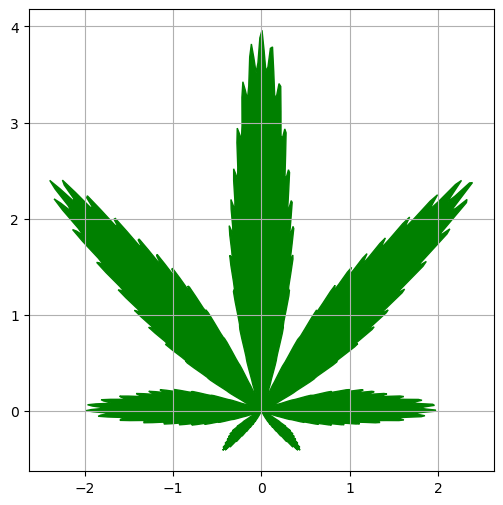

In [20]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1+0.9*torch.cos(8*theta))*(1+0.1*torch.cos(24*theta))*(0.9+0.05*torch.cos(200*theta))*(1+torch.sin(theta))### YOUR CODE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho*torch.cos(theta)### YOUR CODE
y = rho*torch.sin(theta)### YOUR CODE


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()


### Task II: The Game of Life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100_ ]


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [21]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [22]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    
    #<Your code here!>
    filters = torch.Tensor([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    T=Z.clone()
    N=torch.nn.functional.conv2d(T.unsqueeze_(0).unsqueeze_(0),filters.unsqueeze_(0).unsqueeze_(0),padding='same')
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)
    
    Z[:] = birth | survive
    return Z


In [23]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


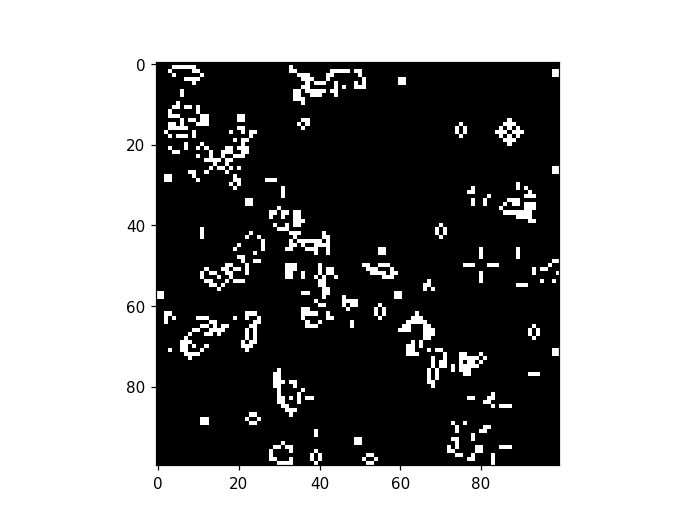

In [24]:
%matplotlib notebook
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


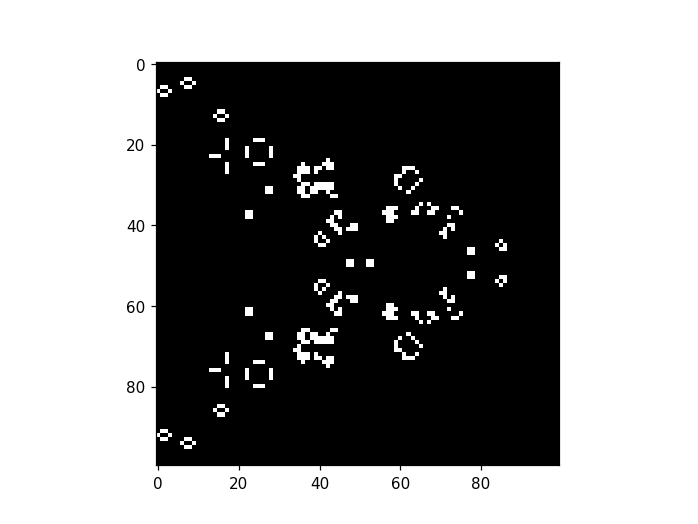

In [25]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE) and/or [Jupyter Notebook](https://nbviewer.jupyter.org/url/norvig.com/ipython/Life.ipynb)

### Task III: Going deeper
<img src="https://habrastorage.org/getpro/habr/upload_files/c9d/efd/e73/c9defde731a050ce1b512ce277c83f08.png" width=480>

Your third trial is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve yet another digit recognition problem, but at a greater scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__ .  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [30]:
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week02_autodiff/notmnist.py

In [31]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [32]:
X_train.shape,y_train.shape,X_train[0],y_train[0]

((14043, 784),
 (14043,),
 array([-0.7821196 ,  0.20976876,  0.90238035,  1.133251  ,  1.2444108 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2444108 ,  1.133251  ,
         0.90238035,  0.20976876, -0.79067034,  0.7655682 ,  1.2529616 ,
         1.2444108 ,  1.2529616 ,  1.2444108 ,  1.2444108 ,  1.2444108 ,
         1.2444108 ,  1.2444108 ,  1.2444108 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2444108 ,  1.2444108 ,  1.2444108 ,  1.2444108 ,
         1.2444108 ,  1.2444108 ,  1.2529616 ,  1.2444108 ,  1.2529616 ,
         0.75701743,  0.7826697 ,  1.2529616 ,  1.2444108 ,  1.2529616 ,
         1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,  1.2529616 ,
         1.2529616 ,  1.2

In [33]:
y_train.shape

(14043,)

<IPython.core.display.Javascript object>


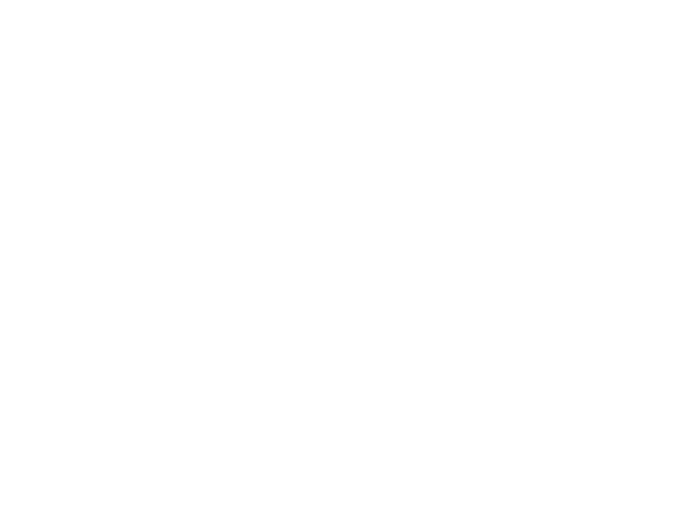

<IPython.core.display.Javascript object>


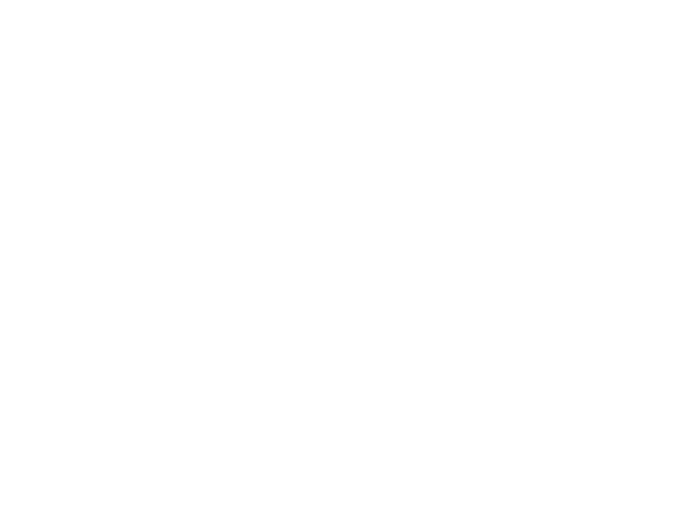

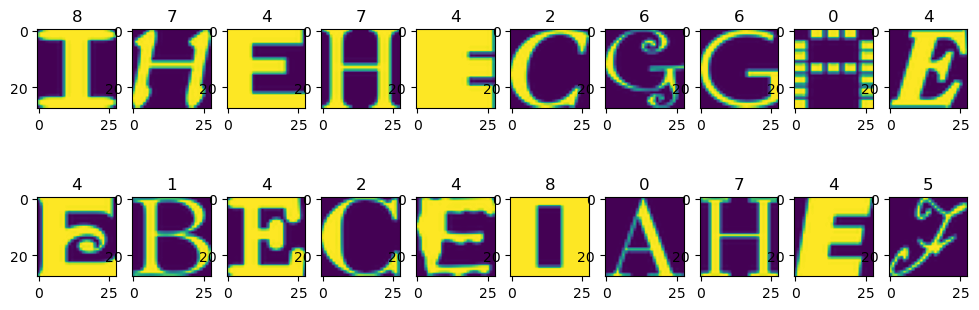

In [34]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [35]:
class model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(n_in,nh),
            nn.ReLU(),
            nn.Linear(nh,n_out),
        )
    #def __call__(self, x, targ=None):
     #   for l in self.layers: 
      #      x = l(x)     
      #  return x
    def forward(self,x):
        x=self.layers(x)
        return x
    #def softmax(self,x):
    #    return nn.functional.log_softmax(x)

In [36]:
def train(epochs,X_train,y_train):
    best_loss=100
    model_=model(784,64,10)
    criterion=nn.CrossEntropyLoss()
    optim=torch.optim.SGD(model_.parameters(),lr=0.001)
    for epoch in range(epochs):
        model_.train()
        loss_list=[]
        for i in range (X_train.shape[0]):
            x,y=X_train[i],y_train[i]
            stamp=torch.tensor([0,0,0,0,0,0,0,0,0,0],dtype=torch.float32)
            stamp[y]=1.0
            optim.zero_grad()
            pred=model_(x)
            loss=criterion(pred,stamp)
            loss.backward()
            optim.step()
            loss_list.append(loss)
        best_loss=min(best_loss,torch.mean(torch.tensor(loss_list)))
        
        print(f"""epoch number = {epoch} 
                   best loss = {best_loss}
                   mean loss = {torch.mean(torch.tensor(loss_list))}""")
    return model_,best_loss 

In [37]:
def test(model,X_test,y_test):
    model.eval()
    loss_list=[]
    correct=0
    for i in range (X_test.shape[0]):
        x,y=X_test[i],y_test[i]
        preds=model(x)
        correct+=(preds.softmax(0).argmax(0)==y)
    print(f'accuracy = {correct*100/X_test.shape[0]}%')

In [38]:
X_train_tensor=torch.tensor(X_train)
y_train_tensor=torch.tensor(y_train)
X_test_tensor=torch.tensor(X_test)
y_test_tensor=torch.tensor(y_test)

In [39]:
network,best_loss=train(25,X_train_tensor,y_train_tensor)

epoch number = 0 
                   best loss = 0.5600367188453674
                   mean loss = 0.5600367188453674
epoch number = 1 
                   best loss = 0.3487228751182556
                   mean loss = 0.3487228751182556
epoch number = 2 
                   best loss = 0.30624955892562866
                   mean loss = 0.30624955892562866
epoch number = 3 
                   best loss = 0.276775062084198
                   mean loss = 0.276775062084198
epoch number = 4 
                   best loss = 0.25323525071144104
                   mean loss = 0.25323525071144104
epoch number = 5 
                   best loss = 0.23270080983638763
                   mean loss = 0.23270080983638763
epoch number = 6 
                   best loss = 0.2146010398864746
                   mean loss = 0.2146010398864746
epoch number = 7 
                   best loss = 0.19778020679950714
                   mean loss = 0.19778020679950714
epoch number = 8 
                   best loss = 0

In [40]:
test(network,X_test_tensor,y_test_tensor)

accuracy = 91.39073181152344%


In [41]:
X_train

array([[-0.7821196 ,  0.20976876,  0.90238035, ...,  0.90238035,
         0.20121801, -0.79067034],
       [-0.9274825 , -0.9274825 , -0.91038096, ..., -0.9189317 ,
        -0.9274825 , -0.9274825 ],
       [ 1.2529616 ,  1.2529616 ,  1.2529616 , ...,  1.2529616 ,
         1.2529616 ,  1.2529616 ],
       ...,
       [ 0.38933474,  1.2529616 ,  1.2187586 , ..., -0.9274825 ,
        -0.9274825 , -0.9274825 ],
       [-0.9274825 , -0.9274825 , -0.9274825 , ..., -0.9274825 ,
        -0.9274825 , -0.9274825 ],
       [-0.9274825 , -0.9274825 , -0.9274825 , ..., -0.9274825 ,
        -0.9274825 , -0.9274825 ]], dtype=float32)

# SPOILERS!

. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
. \
.  Recommended pipeline:

* Adapt logistic regression from seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.

In [42]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_train_predict=logreg.predict(X_train)
mean=np.mean((y_train_predict-y_train)**2)
y_test_predict=logreg.predict(X_test)
mean=np.mean((y_test_predict-y_test)**2)

In [43]:
print(f'accuracy = {(y_test_predict==y_test).sum()*100/len(y_test)}%')

accuracy = 86.62678914761803%
